# Intro

This script is developed to examine to data of 'HR_data.csv', assumed to be located in the folder 'data'.
It makes use of the packages 'numpy', 'pandas', 'matplotlib', 'scikit-learn', and 'scipy'.

### Setup

In [84]:
# Set environment
import warnings
warnings.filterwarnings('ignore')
rdst = 27

# Load libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, leaves_list
from scipy.spatial.distance import pdist
from collections import Counter

### Data

The data set is divided into subsets for easier handling in the following section.

In [85]:
# Load data set
data = pd.read_csv("data/HR_data.csv")

# Separate depending on feature category
idx_data = data.iloc[:, 0]
eda_data = data.loc[:, data.columns.str.startswith("EDA")]
hr_data = data.loc[:, data.columns.str.startswith("HR")]
temp_data = data.loc[:, data.columns.str.startswith("TEMP")]
quest_data = data[['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']]

cols_to_drop = eda_data.columns.union(hr_data.columns).union(temp_data.columns).union(quest_data.columns)
cols_to_drop = cols_to_drop.union([data.columns[0]])
misc_data = data.drop(columns=cols_to_drop)

### Functions

Below are functions defined, used throughout this script.

In [86]:
def dissimilarity(X, labels, k):

    '''
    Compute dissimilarity as defined by Birchfield–Tomasi (1998).

    Inputs:
    X - DataFrame containing observations.
    labels - Array of assigned clusters.
    k - Scalar defining number of clusters.

    Output:
    W_k - within cluster dissimilarity.
    '''
    
    W_k = 0
    
    for cluster in range(k):
        observations = X[labels == cluster]
        N_l = observations.shape[0]
        
        if N_l > 1:
            D_l = np.sum(pdist(observations, metric='euclidean')**2)
            W_k += D_l / (2 * N_l)

    return W_k

In [87]:
# Define class for Hierarchical model to use with Gap statistics
class HierarchicalModel:

    '''
    
    Uses scipy.cluster.hierarchy functions fcluster and linkage to perform hierarchical clustering.

    Z can be provided or will calculated using the given method.

    Adjustments:
    method - single, complete, average, weighted, centroid, median, ward
    criterion - inconsistent, distance, maxclust, monocrit, maxclust_monocrit
    
    '''
    
    def __init__(self, method='ward', criterion='maxclust', Z=None):
        self.method = method
        self.criterion = criterion
        self.Z = Z
        self.n_clusters = None

    def set_params(self, **params):
        self.n_clusters = params.get('n_clusters', self.n_clusters)
        # If Z not provided, compute it later from data in fit_predict

    def fit_predict(self, X):
        # Compute linkage if not already provided
        if self.Z is None:
            self.Z = linkage(X, method=self.method)
            
        return fcluster(self.Z, self.n_clusters, criterion=self.criterion) - 1

In [88]:
def gap_statistics(X, k_max, references=20, random_state=None, model=None):

    '''
    
    Compute gap statistics of clustering method on data set vs simulated reference data.

    Inputs:
    X - DataFrame containing observations.
    k_max - Scalar defining max number of clusters to test.
    references - Scalar defining number of reference data to simulate.
    model - Clustering model to use. Model should take paramters n_clusters and method fit_predict.

    Output:
    log_W_k - log of within cluster dissimilarity of observations.
    expected_log_W_k - log of within cluster dissimilarity of simualted reference data.
    gaps - vector of differences in W_k between observations and simulated reference data.
    gap_diff - vector of difference in gaps between clusters.
    s_k_ref - standard deviations of W_k of simualted reference data.
    s_prime_k - standard error of k calculated from s_k_ref.
    optimal_k - optimal number of cluster determined by the 1-standard error rule.
    
    '''

    if model is None:
        print ('Define clustering model for gap statistics.')
        return

    # Initiate parameters
    log_W_k = np.zeros(k_max - 1)
    expected_log_W_k = np.zeros(k_max - 1)
    gaps = np.zeros(k_max - 1)
    gap_diff = np.zeros(k_max - 2)
    s_k_ref = np.zeros(k_max - 1)
    
    for k in range(2, k_max + 1):
        # Set model paramters and fit to data
        model.set_params(n_clusters = k, random_state = random_state)
        labels = model.fit_predict(X)
        W_k = dissimilarity(X, labels, k)
        log_W_k[k - 2] = np.log(W_k)

        # Dissimilarities for reference data sets
        ref_W_k = np.zeros(references)
        
        for i in range(references):
            # Simulate reference datasets and fit model to each
            reference = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), size=X.shape)
            ref_labels = model.fit_predict(reference)
            ref_W_k[i] = dissimilarity(reference, ref_labels, k)

        # Expected log(W_k) is the mean of reference log dissimilarities
        expected_log_W_k[k - 2] = np.mean(np.log(ref_W_k))
        
        # Gaps are expected_log_W_k - log_W_k
        gaps[k - 2] = expected_log_W_k[k - 2] - log_W_k[k - 2]
        
        # Standard deviation of reference log dissimilarities
        s_k_ref[k - 2] = np.std(np.log(ref_W_k))
        
    for k in range(2, k_max):
        gap_diff[k - 2] = gaps[k - 1] - gaps[k - 2]

    # 1-SE Rule implementation: Gap(k) ≥ Gap(k+1) - s'(k+1)
    s_prime_k = s_k_ref * np.sqrt(1 + 1 / references)
    k_range = np.arange(2, k_max + 1)
    optimal_k = k_max

    for k in range(2, k_max):
        if gaps[k - 2] >= gaps[k - 1] - s_prime_k[k - 1]:
            optimal_k = k
            break

    
    return log_W_k, expected_log_W_k, gaps, gap_diff, s_k_ref, s_prime_k, optimal_k

# Emotional states

The first part of this script aims to cluster samples based on the emotions expressed through the questionaire dataset 'quest_data'.

## Data

### Missing values and odd features

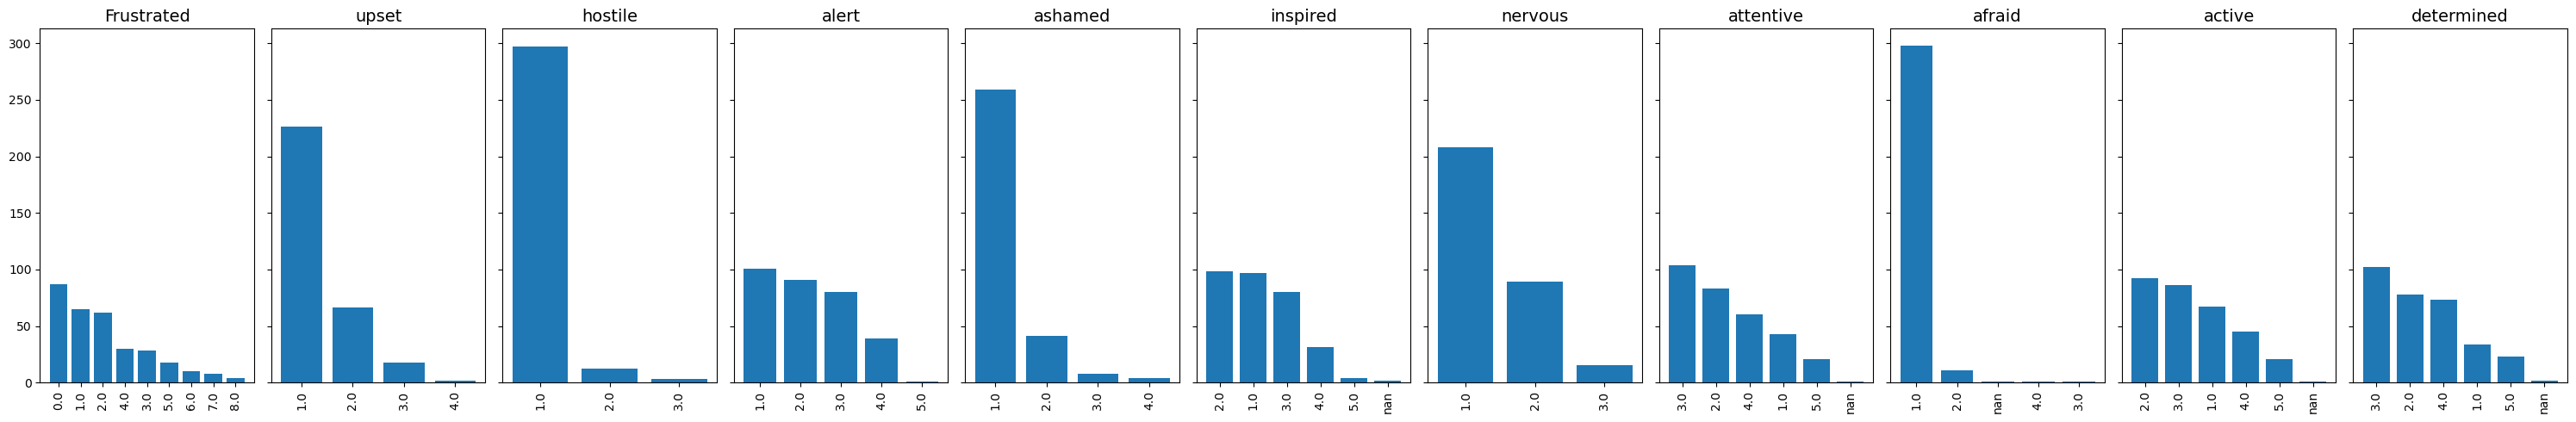

In [89]:
# Feature values
value_counts_per_feature = {
    col: quest_data[col].value_counts(dropna=False)
    for col in quest_data.columns}

# Plot values and NaNs
fig, axes = plt.subplots(1, 11, figsize=(30, 5), sharey=True)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(quest_data.columns):
    counts = quest_data[col].value_counts(dropna=False)
    axes[i].bar(counts.index.astype(str), counts.values)
    axes[i].set_title(col, fontsize=14)
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

The features 'afraid' and 'hsotile' mainly takes the value 1, and are thus removed from future analysis. For the remaining data, rows contianing NaNs are removed.

In [90]:
# Remove 'afraid' and 'hostile' columns
quest_data_cleaned = quest_data.drop(columns=[col for col in quest_data.columns if 'afraid' in col or 'hostile' in col])

# Remove rows with remaining NaNs
nan_row_idx_quest = quest_data_cleaned.isna().any(axis=1)
idx_quest_data_cleaned = idx_data[~nan_row_idx_quest]
quest_data_cleaned = quest_data_cleaned[~nan_row_idx_quest]

# Convert to integers
quest_data_cleaned = quest_data_cleaned.astype(int)

### Scaling

In [91]:
# Normalize to range from 0 to 1
scaler = MinMaxScaler()
normalized_quest_data = pd.DataFrame(
    scaler.fit_transform(quest_data_cleaned),
    columns=quest_data_cleaned.columns,
    index=quest_data_cleaned.index)

In [92]:
# Define feature data
quest_feature_columns = normalized_quest_data.columns.tolist()
quest_features = normalized_quest_data[quest_feature_columns]

### PCA

Principal component analysis is performed and the projection onto the first 2 principal components are saved for future plotting.

In [93]:
# PCA for visualizing clusters
quest_pca = PCA(n_components=2)
quest_pca_result = quest_pca.fit_transform(quest_features)
normalized_quest_data['PCA1'] = quest_pca_result[:, 0]
normalized_quest_data['PCA2'] = quest_pca_result[:, 1]

## Heatmap

A heatmap with a dendrogram is prouduced and a ward linkage matrix, to estimate k visually before applying clustering

[]

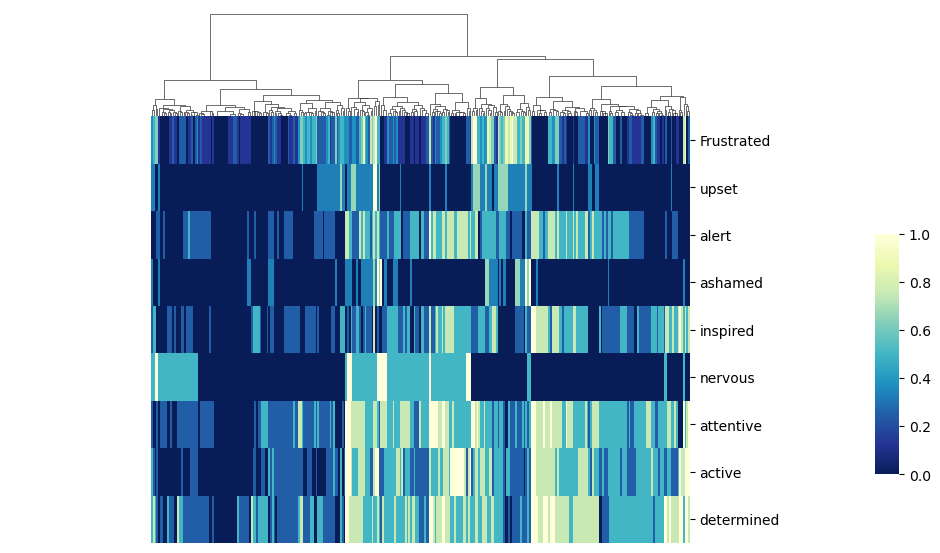

In [94]:
# Create linkage matrix
Z_quest = linkage(quest_features, method='ward')

# Plot heatmap with dendrograms
quest_heatmap = sn.clustermap(quest_features.T, cmap = 'YlGnBu_r', col_linkage = Z_quest, row_cluster = False,
                              col_cluster = True, figsize = (8, 6), cbar_pos = (1.1, .2, .03, .4))
quest_heatmap.ax_heatmap.set_xticks([])

## K-means

The heatmap displays signs of clusters, and K-means clustering is performed to get stable, scalable clusters.

### Silhoutte

K-means is applied for different values of k, and average silhouette scores for the clusters calculated.

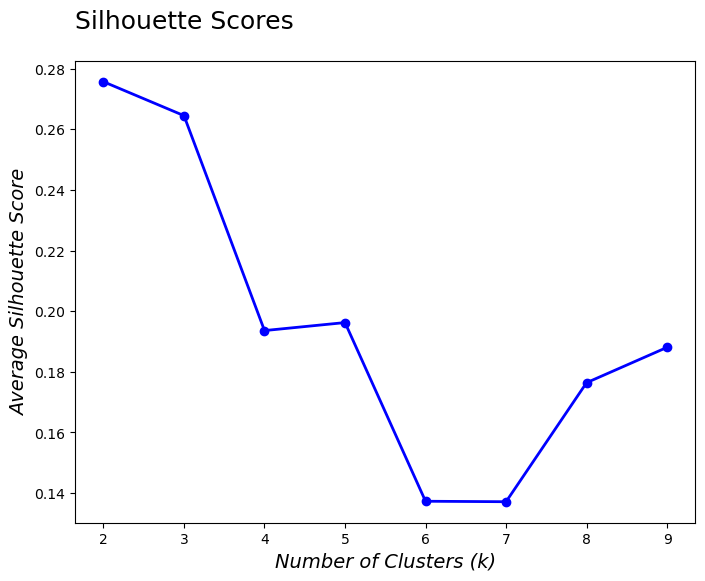

In [95]:
sil_scores = []
k_values = range(2, 10)

# Loop through k values
for k_val in k_values:
    model = KMeans(n_clusters = k_val, random_state = rdst)
    labels = model.fit_predict(quest_features)
    score = silhouette_score(quest_features, labels)
    sil_scores.append(score)

# Plot silhouette scores
kmeans_sil_avg, ax = plt.subplots(figsize=(8, 6))

ax = plt.plot(k_values, sil_scores, 'bo-', linewidth=2)
plt.ylabel("Average Silhouette Score", size = 14, fontstyle = 'italic')
plt.xlabel("Number of Clusters (k)", size = 14, fontstyle = 'italic')
plt.title('Silhouette Scores', y=1.1, pad=-10, loc='left', size=18)

plt.show()

Density plots of sample silhouette scores for k from 2 to 6 is plotted.

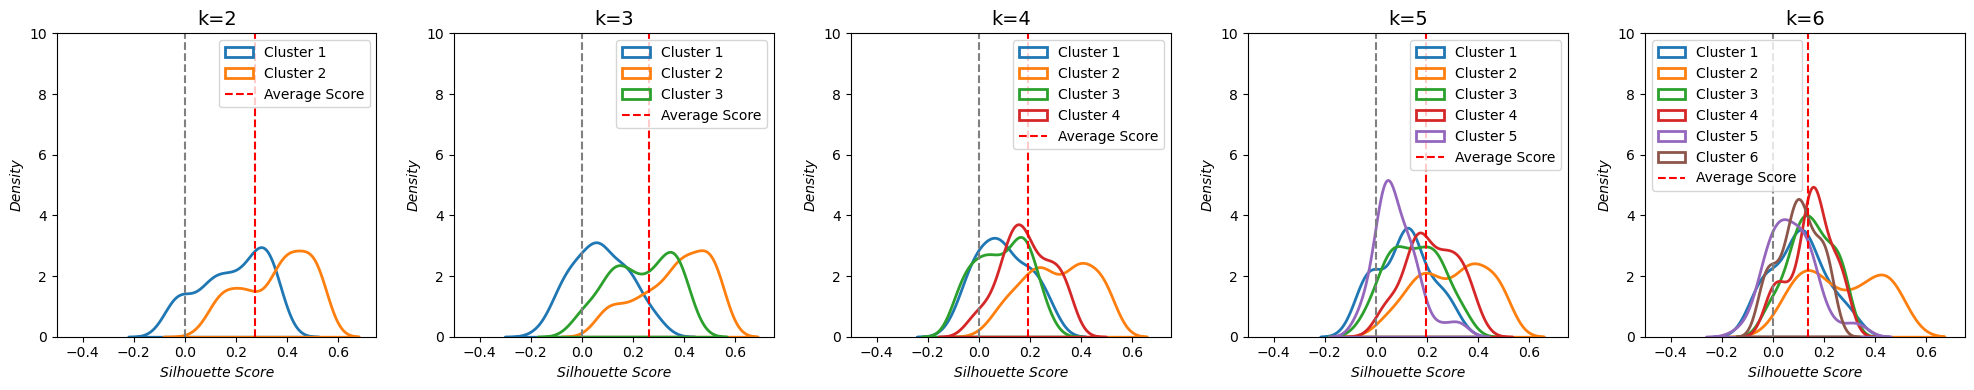

In [96]:
# Set up figure
kmeans_sil_distr, axes = plt.subplots(1, 5, figsize=(20, 4))
k_values = range(2, 7)

# Loop through k values
for idx, k_val in enumerate(k_values):
    
    # Fit KMeans model for k
    model = KMeans(n_clusters = k_val, random_state = rdst)
    labels = model.fit_predict(quest_features)
    
    # Calculate silhouette scores
    sil_scores = silhouette_samples(quest_features, labels)
    
    ax = axes[idx]
    
    # Create separate density plots for each cluster
    for i in range(k_val):
        cluster_sil_scores = sil_scores[labels == i]
        sn.kdeplot(cluster_sil_scores, ax = ax, shade = True, alpha = 0, lw = 2, label = f'Cluster {i+1}')
    
    # Add average silhouette score
    avg_score = silhouette_score(quest_features, labels)
    ax.axvline(x = avg_score, color = 'red', linestyle = '--', label = 'Average Score')

    # Add silhouette score = 0
    ax.axvline(x = 0, color = 'grey', linestyle = '--')
    
    ax.set_title(f'k={k_val}', size = 14)
    ax.set_xlim(-0.5, 0.75)
    ax.set_ylim(0, 10)
    ax.set_xlabel('Silhouette Score', size = 10, fontstyle = 'italic')
    ax.set_ylabel('Density', size = 10, fontstyle = 'italic')
    ax.legend()

plt.tight_layout()
plt.show()

## Gap statistics

The silhouette score indicates that the optimal amount of clusters may be 2, but gap statistics is applied to evaluate this by comparing to a random distribution.

Optimal number of clusters: 5


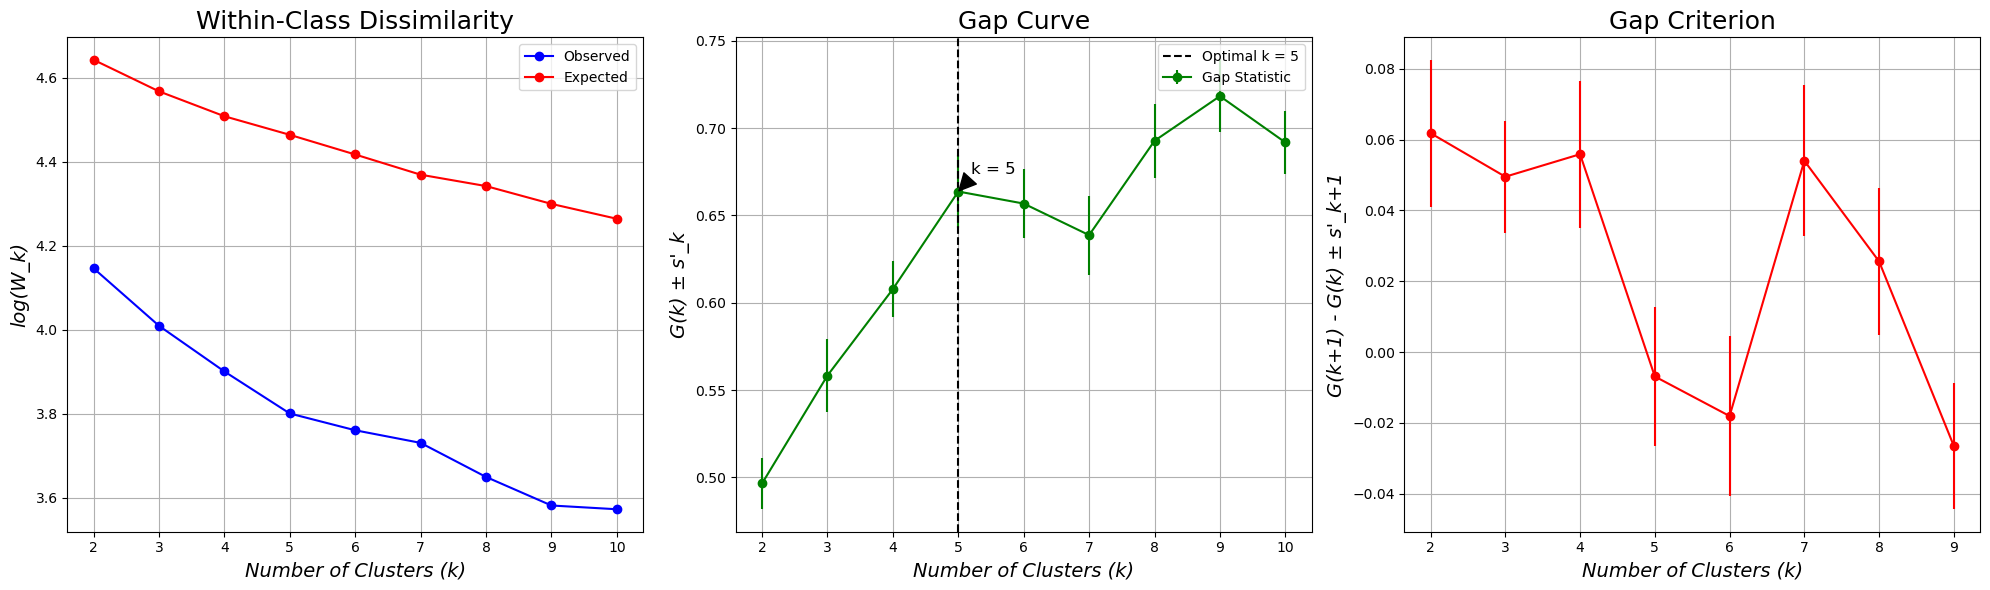

In [97]:
# Compute the gap statistics metrics
k_clusters = 10

(km_log_wk,
km_expected_log_wk,
km_gaps,
km_gap_diff,
km_s_k_ref,
km_s_prime_k,
km_k_1se) = gap_statistics(quest_features, k_clusters, references = 20, random_state = rdst, model = KMeans())

print(f'Optimal number of clusters: {km_k_1se}')

# Set up figure
kmeans_gap, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Within-Class Dissimilarity
axes[0].plot(range(2, k_clusters + 1), km_log_wk, marker = 'o', color = 'b', label = 'Observed')
axes[0].plot(range(2, k_clusters + 1), km_expected_log_wk, marker = 'o', color = 'r', label = 'Expected')
axes[0].set_title('Within-Class Dissimilarity', size = 18)
axes[0].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[0].set_ylabel('log(W_k)', size = 14, fontstyle = 'italic')
axes[0].grid(True)
axes[0].legend()

# Plot 2: Gap Curve
axes[1].errorbar(range(2, k_clusters + 1), km_gaps, yerr = km_s_prime_k, fmt = 'o-', color = 'g', label = 'Gap Statistic')
axes[1].axvline(x = km_k_1se, color = 'black', linestyle = '--', label = f'Optimal k = {km_k_1se}')
axes[1].annotate(f'k = {km_k_1se}', 
                 xy = (km_k_1se, km_gaps[km_k_1se - 2]), 
                 xytext = (km_k_1se + 0.2, km_gaps[km_k_1se - 2] + 0.01), 
                 arrowprops = dict(facecolor = 'black', shrink = 0.05),
                 fontsize = 12)
axes[1].set_title('Gap Curve', size = 18)
axes[1].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[1].set_ylabel('G(k) ± s\'_k', size = 14, fontstyle = 'italic')
axes[1].grid(True)
axes[1].legend()

# Plot 3: Gap Criterion
axes[2].errorbar(range(2, k_clusters), km_gap_diff, yerr = km_s_prime_k[1:], fmt = 'o-', color = 'r', label = 'Gap Criterion')
axes[2].set_title('Gap Criterion', size = 18)
axes[2].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[2].set_ylabel('G(k+1) - G(k) ± s\'_k+1', size = 14, fontstyle = 'italic')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Clustering

Gap statistics indicate that the optimal amount of clusters is 5, and this number is used for further analysis.

In [98]:
# Fit KMeans
n_clusters = km_k_1se
kmeans = KMeans(n_clusters = n_clusters, random_state = rdst)
normalized_quest_data['quest_cluster_kmeans'] = kmeans.fit_predict(quest_features) +1
final_quest_data = pd.concat([idx_quest_data_cleaned, normalized_quest_data], axis=1)

# Print table of cluster mean center
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns = quest_features.columns)
cluster_centers.index = [f'Cluster {i+1}' for i in range(km_k_1se)]
display(cluster_centers)

,Frustrated,upset,alert,ashamed,inspired,nervous,attentive,active,determined
Cluster 1,0.720588,0.480392,0.360294,0.313725,0.205882,1.029412e-01,0.455882,0.426471,0.411765
Cluster 2,0.165441,0.049020,0.095588,0.022876,0.098039,1.176471e-01,0.188725,0.095588,0.223039
Cluster 3,0.224138,0.057471,0.616379,0.011494,0.586207,1.982759e-01,0.737069,0.754310,0.793103
Cluster 4,0.162698,0.052910,0.261905,0.021164,0.365079,-8.326673e-17,0.492063,0.436508,0.555556
Cluster 5,0.254902,0.130719,0.362745,0.156863,0.338235,6.372549e-01,0.568627,0.480392,0.583333


The data is projected over the 2 first principal components, and the cluster labels used to visualize the clusters.

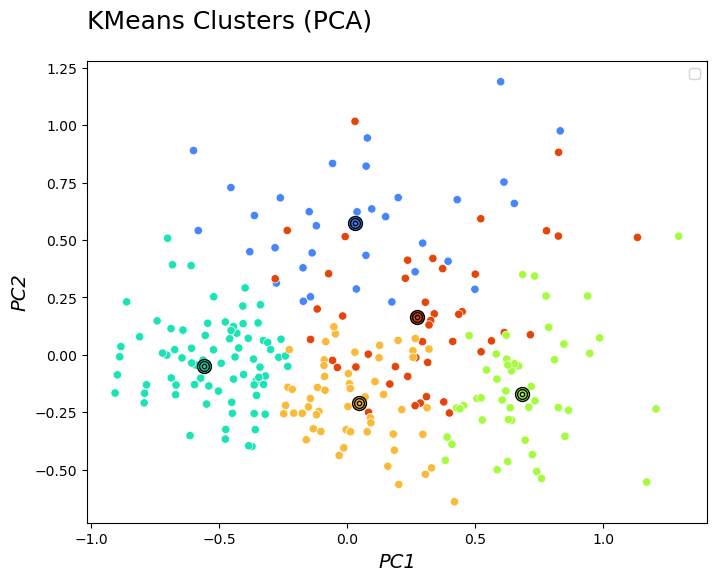

In [99]:
# Create colors based on kmeans
palette = sn.color_palette("turbo", n_clusters)
cluster_labels = normalized_quest_data['quest_cluster_kmeans']
cluster_palette = {label: palette[label - 1] for label in sorted(cluster_labels.unique())}
cluster_colors = cluster_labels.map(lambda x: palette[x-1])

# Project cluster centers to PCA space
centers_pca = quest_pca.transform(cluster_centers)
centers_pca_df = pd.DataFrame(centers_pca, columns=['PCA1', 'PCA2'])
centers_pca_df['Cluster'] = range(1, km_k_1se + 1)


# Plot over principal components
fig, ax = plt.subplots(figsize=(8, 6))

ax = sn.scatterplot(data = normalized_quest_data, x = 'PCA1', y = 'PCA2', hue = 'quest_cluster_kmeans', palette = cluster_palette)
for idx, row in centers_pca_df.iterrows():
    cluster_color = cluster_palette[row['Cluster']]
    for radius in [100, 50, 10]:
        ax.scatter(row['PCA1'], row['PCA2'], s = radius, edgecolor = 'black', facecolor = cluster_color,  linewidth = 1)

ax.set_xlabel('PC1', size = 14, fontstyle = 'italic')
ax.set_ylabel('PC2', size = 14, fontstyle = 'italic')
ax.set_title('KMeans Clusters (PCA)', y=1.1, pad=-10, loc='left', size=18)
plt.legend([])

plt.show()

The previous heatmap with clusters predicted by k-means.

[]

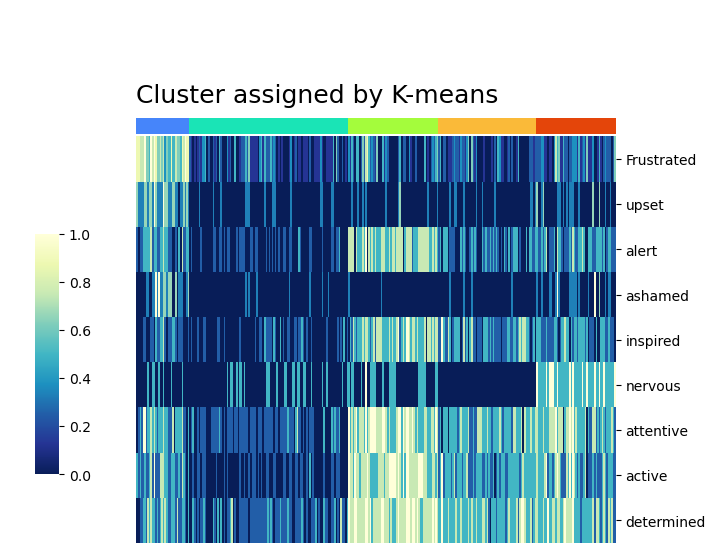

In [100]:
# Sort columns by cluster label
sorted_rows = cluster_labels.sort_values().index
quest_features_sorted = quest_features.loc[sorted_rows, :]

# Plot heatmap with cluster colors
quest_heatmap_km = sn.clustermap(quest_features_sorted.T, cmap = 'YlGnBu_r', row_cluster = False,
                                 col_colors = cluster_colors.loc[sorted_rows], col_cluster = False, figsize = (8, 6),
                                 cbar_pos = (0.05, .2, .03, .4))
quest_heatmap_km.ax_col_colors.set_title("Cluster assigned by K-means", fontsize=18, pad=10 , y=1.1, loc='left', size=18)
quest_heatmap_km.ax_col_colors.set_xticks([])
quest_heatmap_km.ax_col_colors.set_yticks([])
quest_heatmap_km.ax_col_colors.set_xlabel('')
quest_heatmap_km.ax_col_colors.set_ylabel('')
quest_heatmap_km.ax_heatmap.set_xticks([])

### Characterisitics

Characteristics of the identified clusters are explored, both for the distributions of the features within each cluster, but also settings of the original dataset that might correlate to the emotional state.

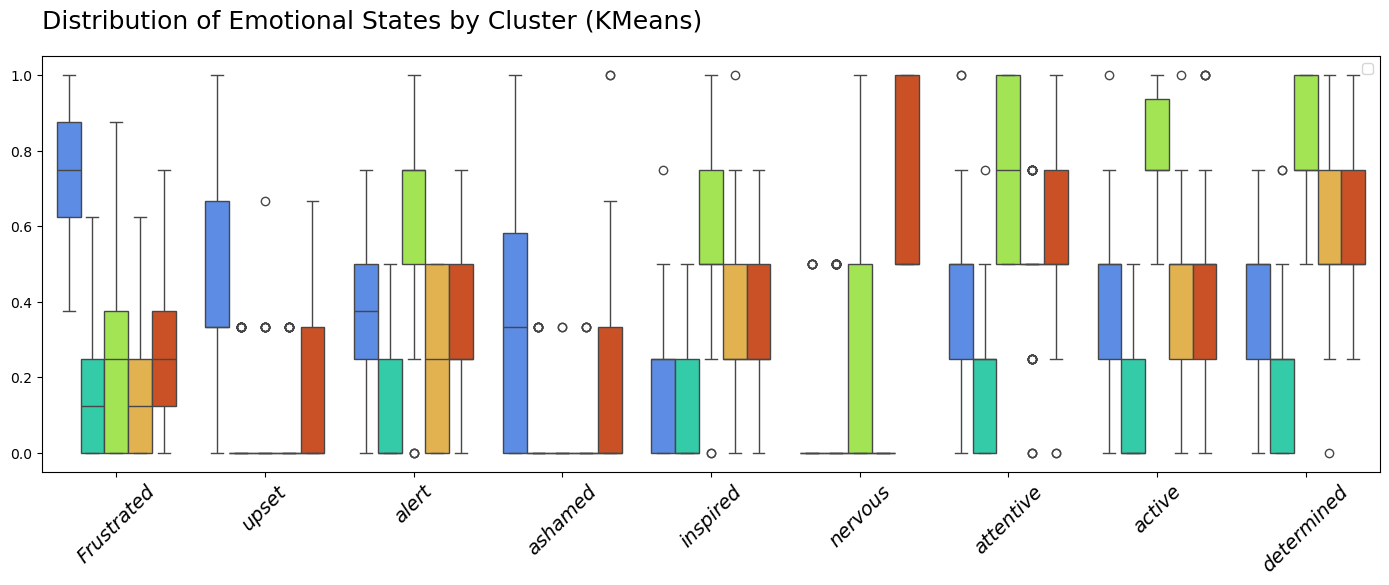

In [101]:
# Boxplots of questionaires for each cluster predicted by kmeans
kmeans_quest_melted = pd.melt(normalized_quest_data.reset_index(),
                              id_vars = 'quest_cluster_kmeans',
                              value_vars = quest_features.columns,
                              var_name = 'Question', value_name='Score')

plt.figure(figsize=(14, 6))
sn.boxplot(data = kmeans_quest_melted, x = 'Question', y = 'Score', hue = 'quest_cluster_kmeans', palette = cluster_palette)
plt.title("Distribution of Emotional States by Cluster (KMeans)", y=1.1, pad=-10, loc='left', size=18)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, size = 14, fontstyle = 'italic')
plt.legend([])
plt.tight_layout()
plt.show()

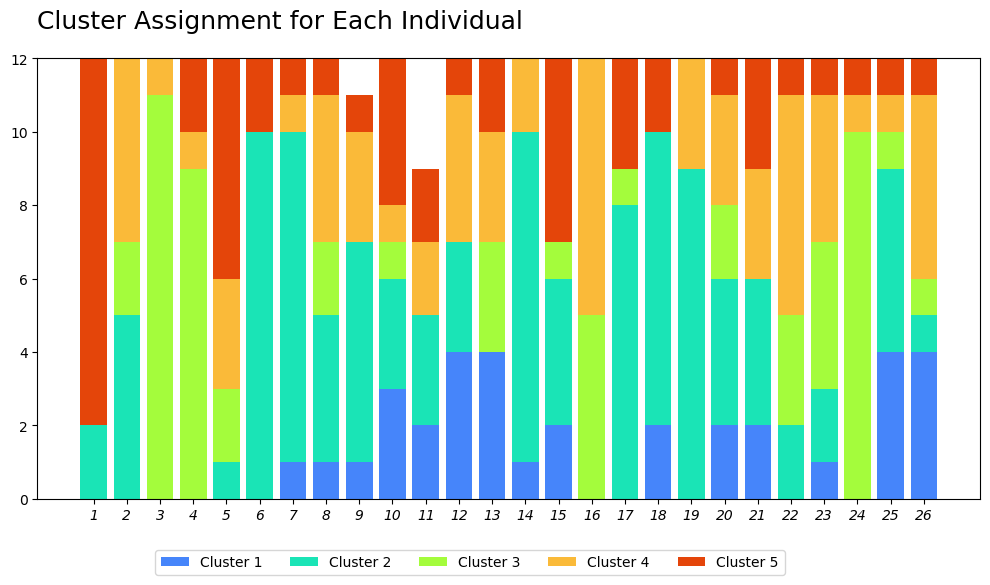

In [102]:
# Add cluster labels to misc data
misc_columns = [col for col in misc_data.columns if col != 'Individual']
misc_data_filtered = misc_data[misc_columns]
misc_data_clustered = misc_data.loc[idx_quest_data_cleaned].copy()
misc_data_clustered['Cluster'] = cluster_labels

# Group by individual to count number of times individual occurs in each cluster
individual_cluster_counts = misc_data_clustered.groupby(['Individual', 'Cluster']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(10, 6))

individuals = misc_data_clustered['Individual'].unique()
clusters = sorted(misc_data_clustered['Cluster'].unique())
bar_width = 0.8  # Width for each stacked bar
x = np.arange(len(individuals))

# Plot stacked bars for each individual
previous_heights = np.zeros(len(individuals))  # Initialize the previous heights for stacking

for cluster in clusters:
    # Get the counts for each individual for the current cluster
    cluster_data = individual_cluster_counts[individual_cluster_counts['Cluster'] == cluster]
    
    # Create a list of counts for each individual
    heights = []
    for individual in individuals:
        count = cluster_data[cluster_data['Individual'] == individual]['Count']
        heights.append(count.values[0] if len(count) > 0 else 0)  # Add 0 if the individual is not assigned to this cluster

    # Stack the bars for each cluster
    ax.bar(x, heights, bottom=previous_heights, width=bar_width, color=cluster_palette[cluster], label=f'Cluster {cluster}')
    
    # Update the previous heights to include the current cluster
    previous_heights += np.array(heights)

# Set x-ticks for each individual
ax.set_xticks(x)
ax.set_xticklabels(individuals, size=10, fontstyle='italic')
ax.set_ylabel('', size=10, fontstyle='italic')
ax.set_title("Cluster Assignment for Each Individual", y=1.1, pad=-10, loc='left', size=18)
ax.legend(title='', bbox_to_anchor = (0.2, -0.1, 0.6, 0), ncols = n_clusters)

plt.tight_layout()
plt.show()


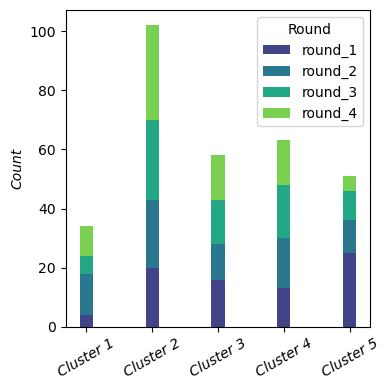

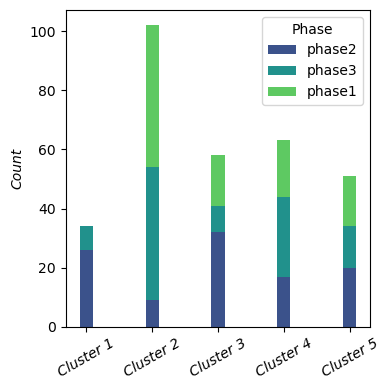

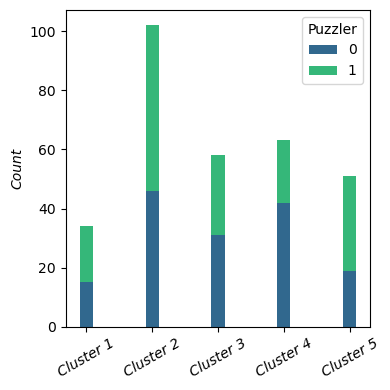

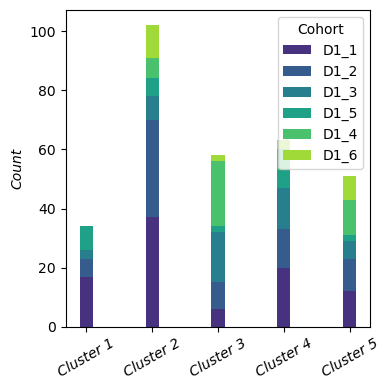

In [103]:
# Melt data to variable occurence in each cluster 
quest_melted_misc = misc_data_clustered.melt(id_vars='Cluster', 
                                              var_name='Variable', 
                                              value_name='Category')

# Plot each misc feature other than individual
variables = [col for col in misc_data.columns if col != 'Individual']
clusters = sorted(misc_data_clustered['Cluster'].unique())
bar_width = 0.8 / len(variables)
x = np.arange(len(clusters))

for i, var in enumerate(variables):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Group by Cluster, Variable, and Category to get counts
    grouped = (quest_melted_misc[quest_melted_misc['Variable'] == var]
               .groupby(['Cluster', 'Category'])
               .size()
               .reset_index(name='Count'))

    categories = grouped['Category'].unique()
    bottom = np.zeros(len(clusters))

    # Set a color palette for the categories
    palette = sn.color_palette("viridis", len(categories))
    color_map = dict(zip(categories, palette))
    
    for cat in categories:
        heights = []
        for cluster in clusters:
            count = grouped[(grouped['Cluster'] == cluster) & (grouped['Category'] == cat)]['Count']
            heights.append(count.values[0] if len(count) > 0 else 0)  # Add 0 if the category is missing in a cluster
        
        ax.bar(x + bar_width, heights, bottom = bottom, width = bar_width, color = color_map[cat], label = cat)
        bottom += np.array(heights)

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels([f"Cluster {c}" for c in clusters], rotation = 30, size = 10, fontstyle = 'italic')
    ax.set_ylabel("Count", size = 10, fontstyle = 'italic')
    ax.set_title('')
    ax.legend(title = var, loc = 'upper right')

    plt.tight_layout()
    plt.show()

# Physiological response

In order to further explore characterization of the groups, data of the physiological responses are explored by similar means of clustering.

## Data

### Missing values

In [104]:
# Combine all physiological columns
phys_data = pd.concat([eda_data, hr_data, temp_data], axis=1)
phys_data_cleaned = phys_data.loc[idx_quest_data_cleaned].copy()
phys_feature_columns = phys_data_cleaned.columns.values.tolist()
phys_feature_no = phys_data_cleaned.shape[1]

In [105]:
# Locate NaNs
np.where(phys_data_cleaned.isna() == True)

(array([268, 268]), array([25, 26]))

Only one sample has missing values, and this row is removed from further analysis.

In [106]:
# Remove rows with NaNs
nan_row_idx_phys = phys_data_cleaned.isna().any(axis=1)
phys_data_cleaned = phys_data_cleaned[~nan_row_idx_phys]
idx_phys_data_cleaned = idx_quest_data_cleaned[~nan_row_idx_phys]

### Separate into clusters

In [107]:
phys_data_indexed = pd.concat([idx_phys_data_cleaned, phys_data_cleaned], axis=1)
idx_final = final_quest_data.columns[0]
idx_phys = phys_data_indexed.columns[0]
merged = phys_data_indexed.merge(final_quest_data[[idx_final, 'quest_cluster_kmeans']], left_on=idx_phys, right_on=idx_final)

# Create optimal k clusters
n_clusters = merged['quest_cluster_kmeans'].nunique()
clusters = {}
for k in range(n_clusters):
    # Create cluster-specific indexed data
    cluster_indexed = merged[merged['quest_cluster_kmeans'] == k+1]
    cluster_phys_data = cluster_indexed[phys_feature_columns]
    
    # Print number of samples in cluster
    print(f'Samples in Cluster {k+1}: {cluster_phys_data.shape[0]}')
    
    # Store cluster data
    clusters[k] = cluster_phys_data

Samples in Cluster 1: 34
Samples in Cluster 2: 102
Samples in Cluster 3: 58
Samples in Cluster 4: 62
Samples in Cluster 5: 51


### Scaling

In [108]:
# Scale each feature from 0 to 1 and define feature data
scaler = MinMaxScaler()
normalized_phys_data = pd.DataFrame(
    scaler.fit_transform(phys_data_cleaned),
    columns = phys_data_cleaned.columns,
    index = phys_data_cleaned.index)
phys_features_all = normalized_phys_data[phys_feature_columns]
scaler_fitted = scaler.fit(phys_data_cleaned)

normalized_phys_clusters = {}
phys_features_all_clusters = {}

# Repeat for clusters
for k in range(n_clusters):
    cluster_phys_data = clusters[k]
    normalized_data = pd.DataFrame(
        scaler_fitted.transform(cluster_phys_data),
        columns = cluster_phys_data.columns,
        index = cluster_phys_data.index)
    
    normalized_phys_clusters[k] = normalized_data
    phys_features_cluster_k = normalized_phys_clusters[k][phys_feature_columns]
    phys_features_all_clusters[k] = phys_features_cluster_k 

### PCA

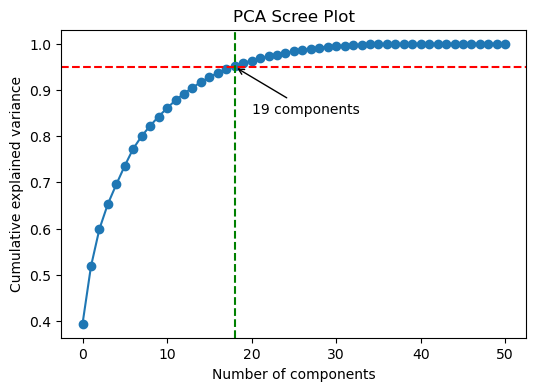

In [109]:
# PCA for visualizing clusters
phys_pca = PCA(n_components=2)
phys_pca_result = phys_pca.fit_transform(phys_features_all)
normalized_phys_data['PCA1'] = phys_pca_result[:, 0]
normalized_phys_data['PCA2'] = phys_pca_result[:, 1]

phys_pca_results_all_clusters = {}

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    phys_pca_result_cluster_k = phys_pca.fit_transform(phys_features_cluster_k)
    normalized_phys_clusters[k]['PCA1'] = phys_pca_result_cluster_k[:, 0]
    normalized_phys_clusters[k]['PCA2'] = phys_pca_result_cluster_k[:, 1]
    phys_pca_results_all_clusters[k] = normalized_phys_clusters[k]

# Scree plot of overall data
phys_pca2 = PCA(n_components = phys_feature_no)
phys_pca2_results = phys_pca2.fit_transform(phys_features_all)

phys_cum_var = np.cumsum(phys_pca2.explained_variance_ratio_)
phys_n_95 = np.argmax(phys_cum_var >= 0.95) + 1

plt.figure(figsize=(6, 4))
plt.plot(phys_cum_var, marker='o')

plt.axhline(y = 0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x = phys_n_95 - 1, color='g', linestyle='--', label=f'{phys_n_95} components')
plt.annotate(f"{phys_n_95} components", xy=(phys_n_95 - 1, 0.95), xytext=(phys_n_95 + 1, 0.85), arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.show()

## Heatmaps

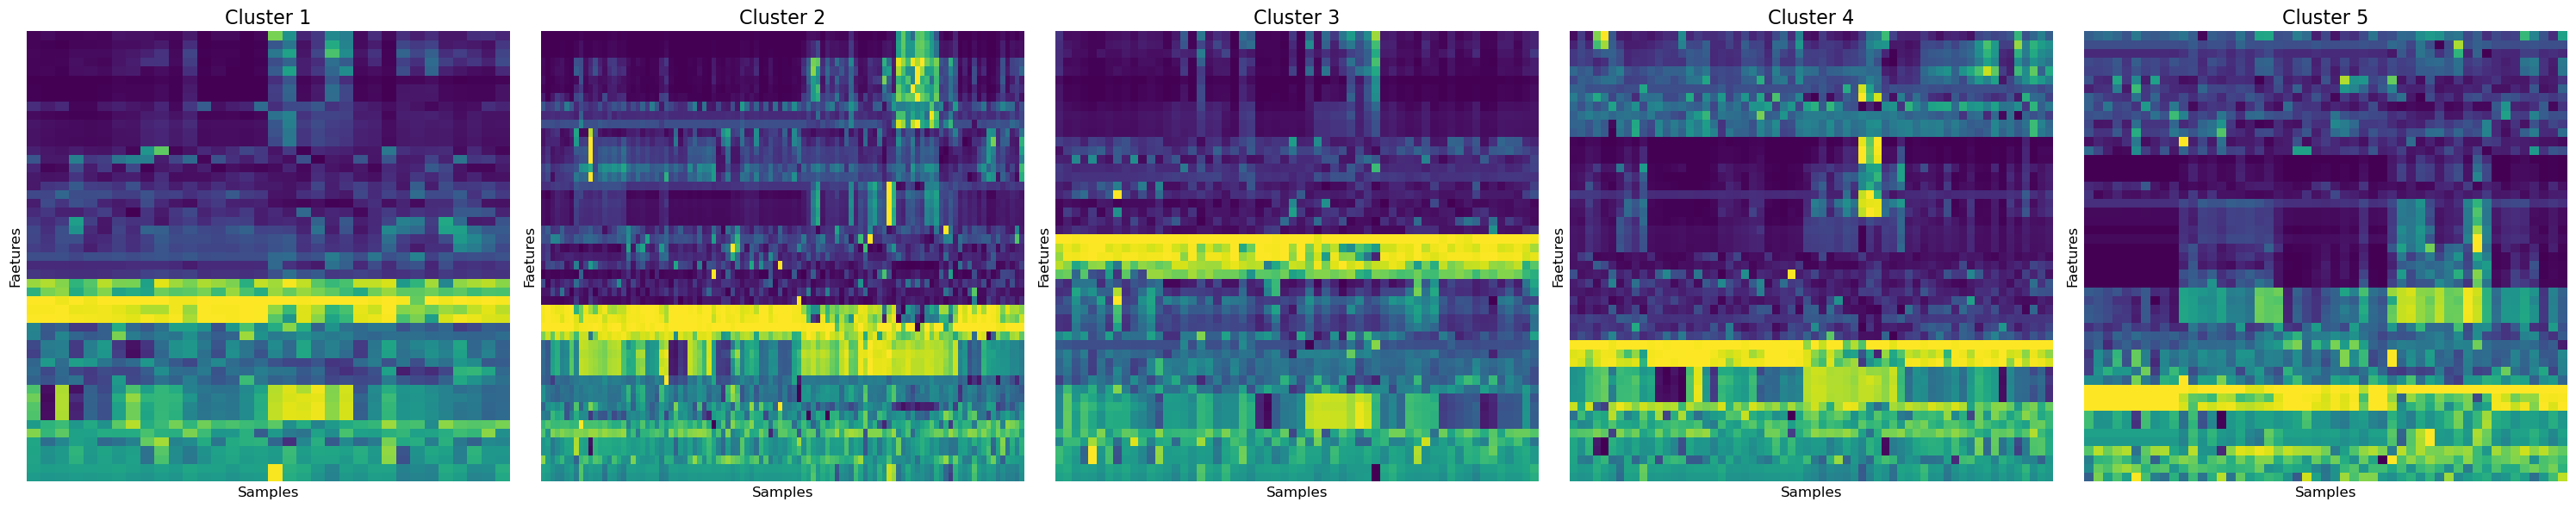

In [110]:
# Set up one figure with subplots
fig, axes = plt.subplots(1, n_clusters, figsize=(6 * n_clusters, 6), squeeze=False)
axes = axes.flatten()

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    Z_k = linkage(phys_features_cluster_k.T, method='ward')
    col_order = leaves_list(Z_k)
    ordered_features = phys_features_cluster_k.T.iloc[col_order]
    
    sn.heatmap(ordered_features,
               cmap='viridis',
               ax=axes[k],
               cbar=False)
    
    axes[k].set_title(f'Cluster {k+1}', size=16)
    axes[k].set_xlabel('Samples', size=12)
    axes[k].set_ylabel('Faetures', size=12)
    axes[k].set_xticks([])
    axes[k].set_yticks([])

plt.tight_layout()
plt.show()

## PCA

The heatmap displays some signs of clusters, but not as strongly as previously seen. The projections onto principal components are plotted to further visulize clustering possibilities.

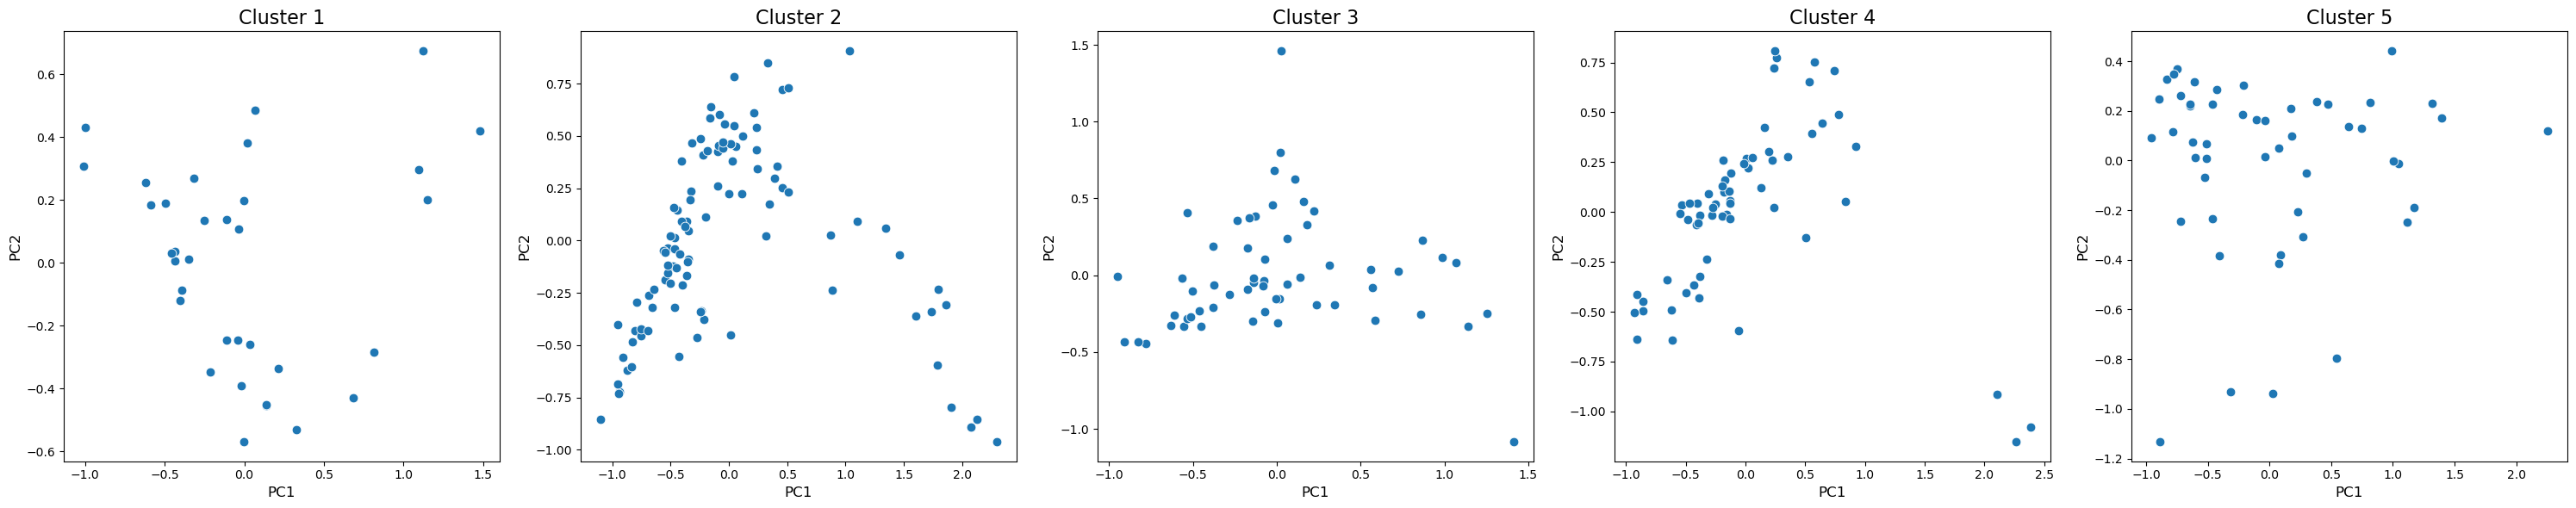

In [111]:
# Set up one figure with subplots
fig, axes = plt.subplots(1, n_clusters, figsize=(6 * n_clusters, 6), squeeze=False)
axes = axes.flatten()

for k in range(n_clusters):
    cluster_pca_data = phys_pca_results_all_clusters[k]
    
    ax = axes[k]
    sn.scatterplot(data=cluster_pca_data, x='PCA1', y='PCA2', ax=ax, s=60)
    
    ax.set_title(f'Cluster {k+1}', size=16)
    ax.set_xlabel('PC1', size=12)
    ax.set_ylabel('PC2', size=12)

plt.tight_layout()
plt.show()

## Hierarchical clustering

Obvious signs of clusters are not present, so hierarchical clustering is used for further exploration, due to the limited sizes of the data subsets.

### Silhouette

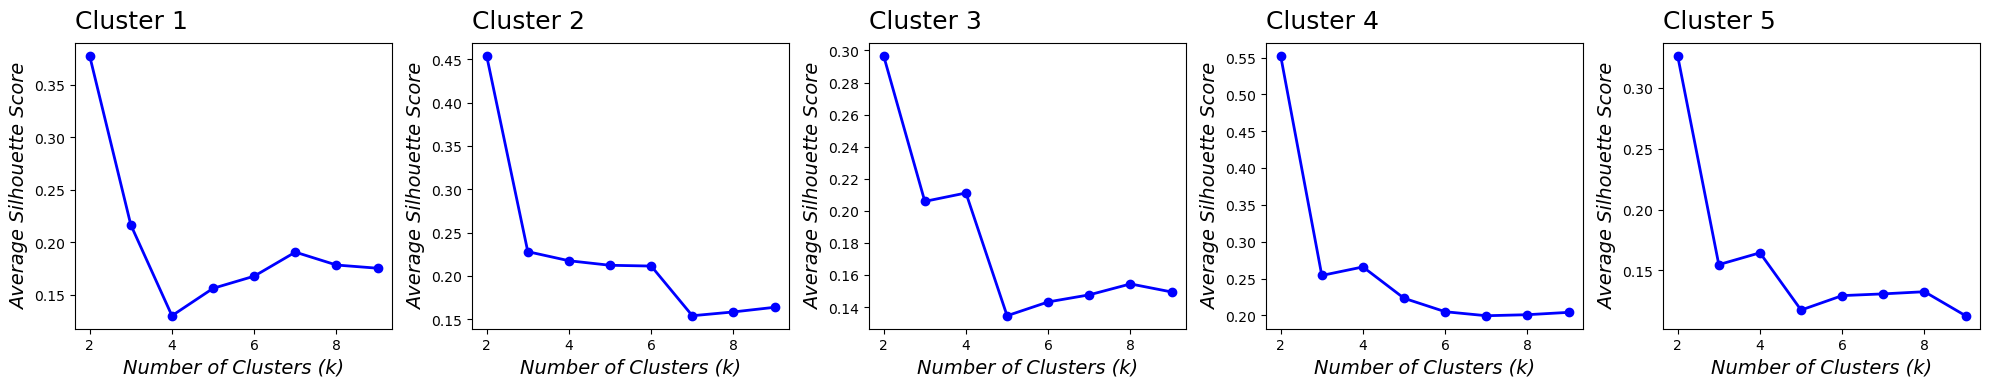

In [112]:
# Set up the figure with subplots
fig, axes = plt.subplots(1, n_clusters, figsize=(20, 4))

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    Z_k = linkage(phys_features_cluster_k, method='ward')
    sil_scores = []
    k_values = range(2, 10)
    
    for k_val in k_values:
        labels = fcluster(Z_k, k_val, criterion='maxclust')
        score = silhouette_score(phys_features_cluster_k, labels)
        sil_scores.append(score)
    
    ax = axes[k]
    ax.plot(k_values, sil_scores, 'bo-', linewidth=2)
    ax.set_xlabel("Number of Clusters (k)", size=14, fontstyle='italic')
    ax.set_ylabel("Average Silhouette Score", size=14, fontstyle='italic')
    ax.set_title(f'Cluster {k+1}', y=1.1, pad=-10, loc='left', size=18)

plt.tight_layout()
plt.show()

### Gap statistics

Optimal number of clusters for cluster 1: 10
Optimal number of clusters for cluster 2: 10
Optimal number of clusters for cluster 3: 10
Optimal number of clusters for cluster 4: 10
Optimal number of clusters for cluster 5: 10


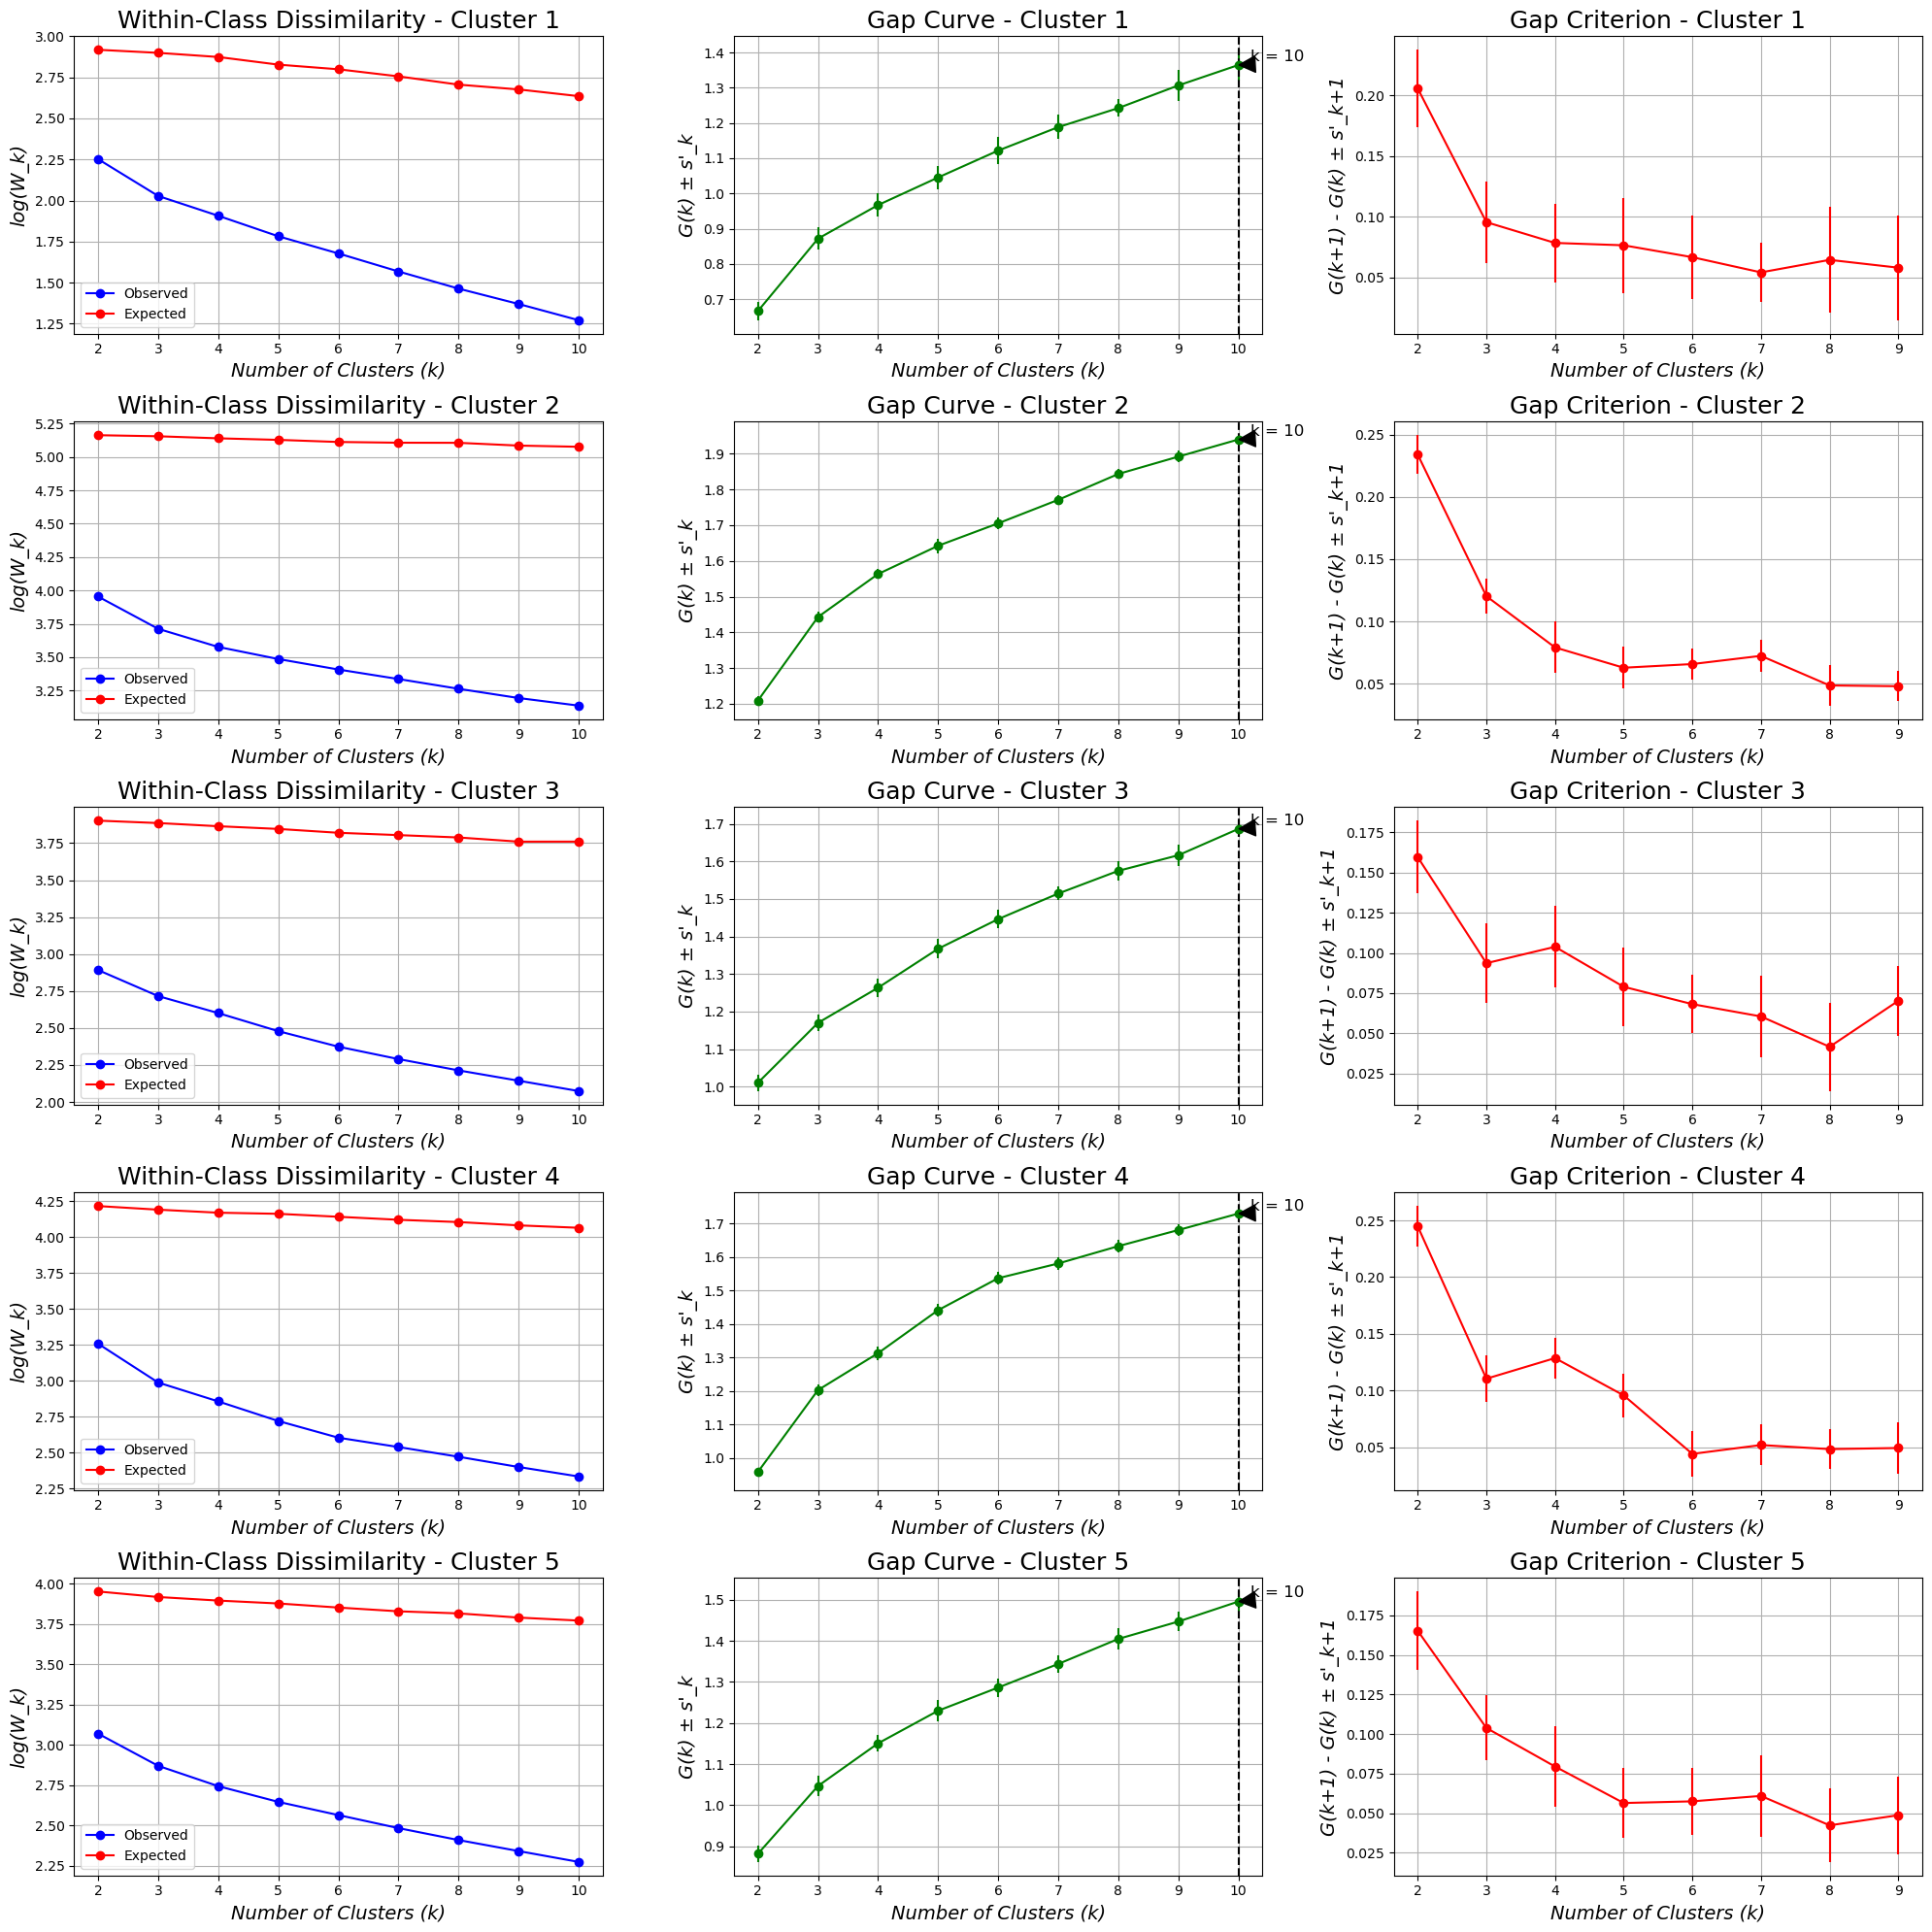

In [113]:
k_clusters = 10
phys_optimal_clusters = {}

# Set figure with 3 cols and n clusters rows
fig, axes = plt.subplots(n_clusters, 3, figsize = (20, 4 * n_clusters))

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    hierach_model = HierarchicalModel(method = 'ward', criterion = 'maxclust')
    
    (phys_log_wk,
     phys_expected_log_wk,
     phys_gaps,
     phys_gap_diff,
     phys_s_k_ref,
     phys_s_prime_k,
     phys_k_1se) = gap_statistics(phys_features_cluster_k, k_clusters, references = 20, random_state = rdst, model = hierach_model)
    
    phys_optimal_clusters[k] = phys_k_1se
    print(f'Optimal number of clusters for cluster {k + 1}: {phys_k_1se}')

    # Plot 1: Within-Class Dissimilarity
    axes[k, 0].plot(range(2, k_clusters + 1), phys_log_wk, marker = 'o', color = 'b', label = 'Observed')
    axes[k, 0].plot(range(2, k_clusters + 1), phys_expected_log_wk, marker = 'o', color = 'r', label = 'Expected')
    axes[k, 0].set_title(f'Within-Class Dissimilarity - Cluster {k + 1}', size = 18)
    axes[k, 0].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
    axes[k, 0].set_ylabel('log(W_k)', size = 14, fontstyle = 'italic')
    axes[k, 0].grid(True)
    axes[k, 0].legend()

    # Plot 2: Gap Curve
    axes[k, 1].errorbar(range(2, k_clusters + 1), phys_gaps, yerr = phys_s_prime_k, fmt = 'o-', color = 'g', label = 'Gap Statistic')
    axes[k, 1].axvline(x = phys_k_1se, color = 'black', linestyle = '--', label = f'Optimal k = {phys_k_1se}')
    axes[k, 1].annotate(f'k = {phys_k_1se}', 
                 xy = (phys_k_1se, phys_gaps[phys_k_1se - 2]), 
                 xytext = (phys_k_1se + 0.2, phys_gaps[phys_k_1se - 2] + 0.01), 
                 arrowprops = dict(facecolor = 'black', shrink=0.05),
                 fontsize = 12)
    axes[k, 1].set_title(f'Gap Curve - Cluster {k + 1}', size = 18)
    axes[k, 1].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
    axes[k, 1].set_ylabel('G(k) ± s\'_k', size = 14, fontstyle = 'italic')
    axes[k, 1].grid(True)

    # Plot 3: Gap Criterion
    axes[k, 2].errorbar(range(2, k_clusters), phys_gap_diff, yerr = phys_s_prime_k[1:], fmt = 'o-', color = 'r', label = 'Gap Criterion')
    axes[k, 2].set_title(f'Gap Criterion - Cluster {k + 1}', size = 18)
    axes[k, 2].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
    axes[k, 2].set_ylabel('G(k+1) - G(k) ± s\'_k+1', size = 14, fontstyle = 'italic')
    axes[k, 2].grid(True)

plt.tight_layout()
plt.show()

### Clustermaps

As the optimal number of clusters determined by gap statistics seem unresonable and the silhoutte scores continously indicate 2

First, a clustermap is made of clusters 1 through 5.

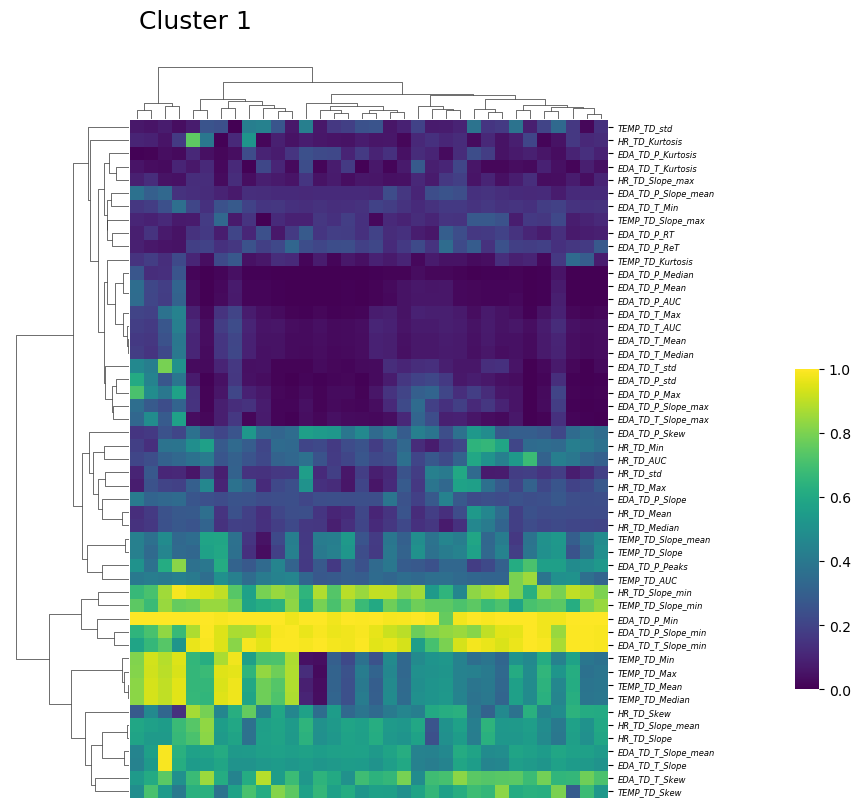

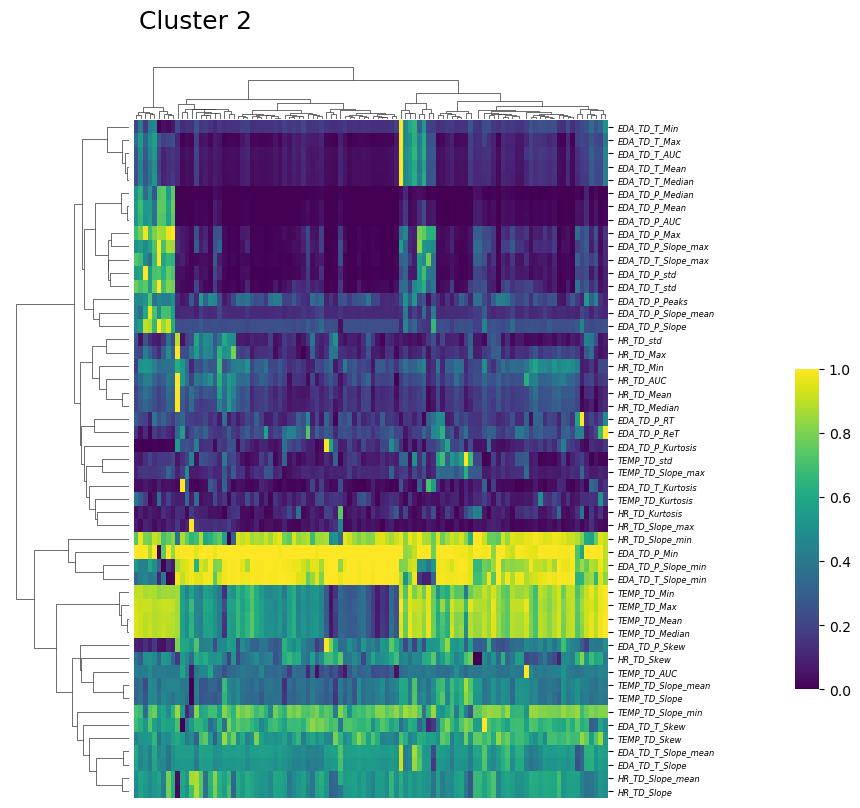

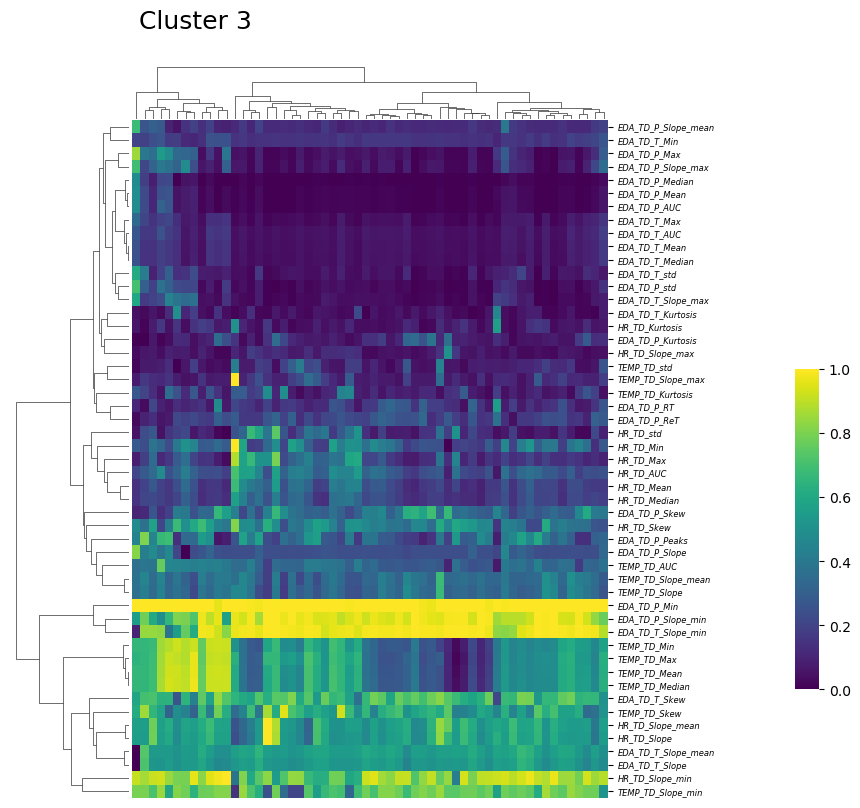

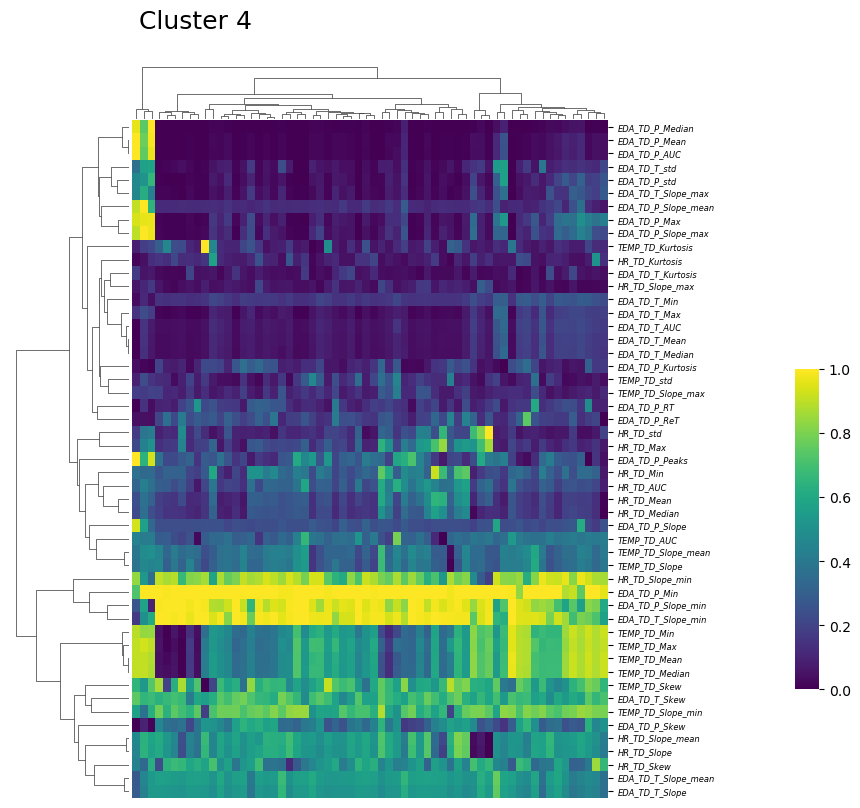

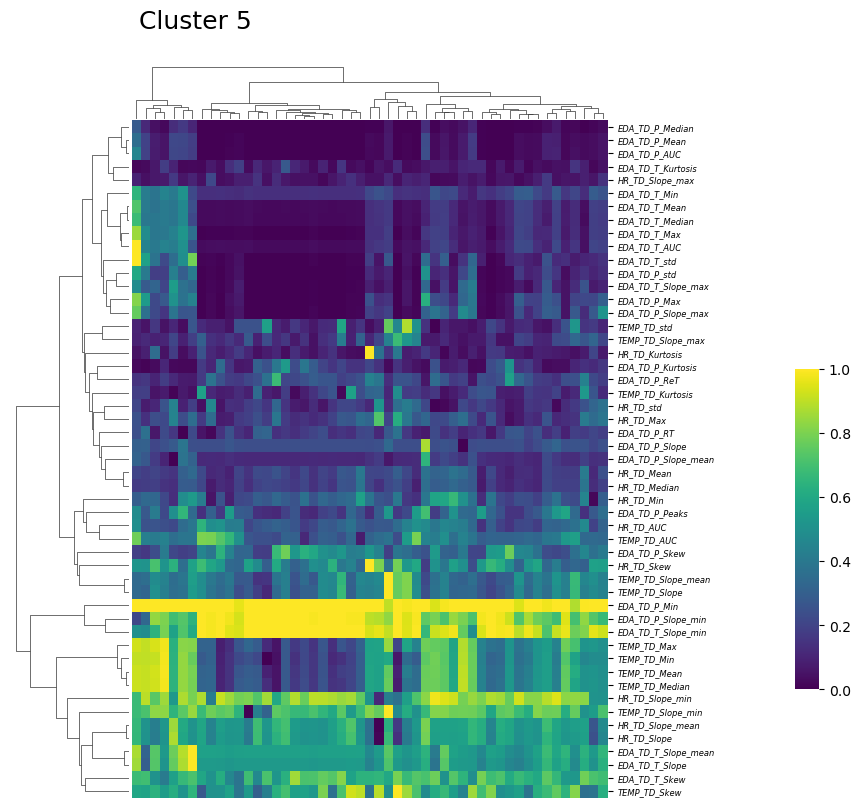

In [114]:
for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    Z_k = linkage(phys_features_cluster_k, method='ward')

    cm = sn.clustermap(phys_features_cluster_k.T, cmap = 'viridis',
              col_linkage = Z_k, row_cluster = True, dendrogram_ratio=(.2, .075),
              figsize = (8, 8), cbar_pos = (1, .2, .03, .4), yticklabels=True)
    
    cm.fig.suptitle(f'Cluster {k+1}', y = 1.05, x = 0.25, size = 18)
    cm.ax_heatmap.set_xticks([])
    cm.ax_heatmap.set_xlabel('')
    cm.ax_heatmap.set_yticklabels(cm.ax_heatmap.get_ymajorticklabels(), rotation=0, fontsize=6, fontstyle = 'italic')

Then, a clustermap is made of all samples.

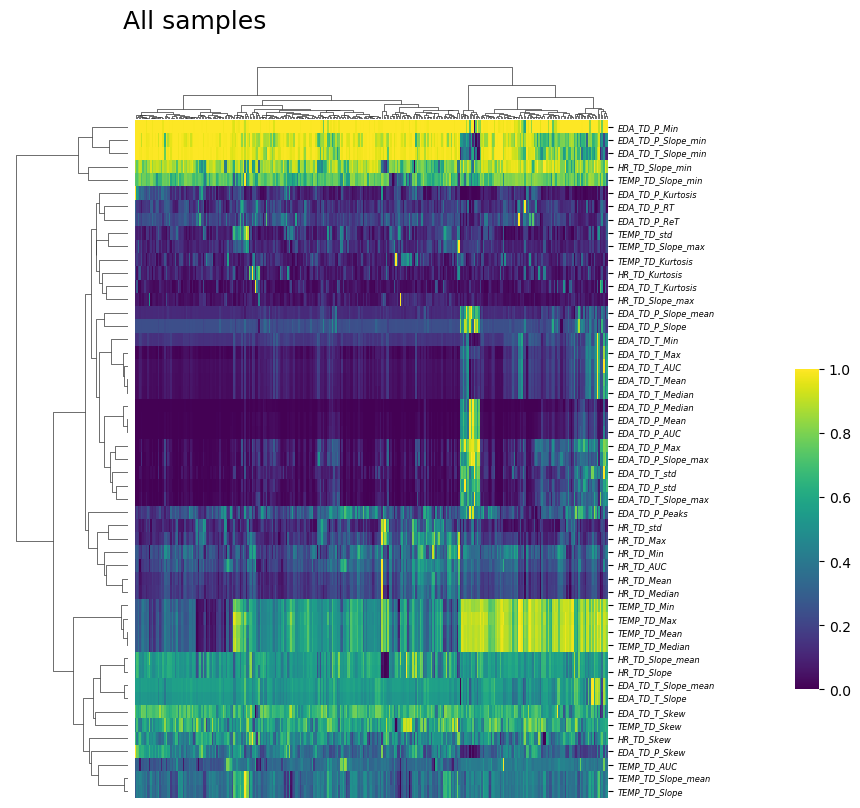

In [115]:
Z_all = linkage(phys_features_all, method='ward')

cm = sn.clustermap(phys_features_all.T, cmap = 'viridis',
                   col_linkage = Z_all, row_cluster = True, dendrogram_ratio=(.2, .075),
                   figsize = (8, 8), cbar_pos = (1, .2, .03, .4), yticklabels=True)
    
cm.fig.suptitle(f'All samples', y = 1.05, x = 0.25, size = 18)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_yticklabels(cm.ax_heatmap.get_ymajorticklabels(), rotation=0, fontsize=6, fontstyle = 'italic')

plt.show()

## Characterizing features

The clustermaps of each cluster, appears to support 2 subclusters within each, and the identification of features of interest will be done for each cluster, as well as for each of their subclusters.

### Subclusters

In [116]:
n_subclusters = 2
subclusters = {}

for k in range(n_clusters):
    cluster_k = phys_features_all_clusters[k]
    Z_k = linkage(cluster_k, method='ward')
    hierarch_labels_k = fcluster(Z_k, n_subclusters, criterion='maxclust')

    for k_sub in range(1, n_subclusters + 1):
        subcluster_k_sub = cluster_k[hierarch_labels_k == k_sub]
        subclusters[f'cluster_{k+1}_sub{k_sub}'] = subcluster_k_sub

for name, df in subclusters.items():
    print(f'Cluster {name}: {df.shape[0]} samples')

Cluster cluster_1_sub1: 4 samples
Cluster cluster_1_sub2: 30 samples
Cluster cluster_2_sub1: 9 samples
Cluster cluster_2_sub2: 93 samples
Cluster cluster_3_sub1: 12 samples
Cluster cluster_3_sub2: 46 samples
Cluster cluster_4_sub1: 3 samples
Cluster cluster_4_sub2: 59 samples
Cluster cluster_5_sub1: 7 samples
Cluster cluster_5_sub2: 44 samples


### Features of interest

The variance and similarity of each feature is calculated. For similarity, correlation scores using pairwise correlation (Pearson) is used. This is done for all data, each cluster, and each subsluster. The globally low variance features and high similiarity features are removed from the cluster and subcluster features, and the the intersecting features of the two lists are defined as the features of variance.

In [117]:
# Variances for all data
feature_variances_all = phys_features_all.var(axis=0)
low_variance_threshold = 0.01
global_low_variance_features = feature_variances_all[feature_variances_all < low_variance_threshold].index.tolist()

print(f'\nFor all samples, there are {len(global_low_variance_features)} low variance features')

# Correlations for all data
feature_corr_all = phys_features_all.corr()
feature_corr_all_abs = feature_corr_all.abs()

# Choose features 1 std**2 over mean
feature_mean_corr_all = feature_corr_all_abs.mean(axis=0)
mean_corr = feature_mean_corr_all.mean()
std_corr = feature_mean_corr_all.std()
high_sim_threshold = mean_corr + std_corr
global_high_sim_features = feature_mean_corr_all[feature_mean_corr_all > high_sim_threshold].index.tolist()

print(f'For all samples, there are {len(global_high_sim_features)} high similarity features')


For all samples, there are 5 low variance features
For all samples, there are 14 high similarity features


In [118]:
# Within each cluster application
low_variance_features = {}
cleaned_low_variance_features = {}
high_sim_features = {}
cleaned_high_sim_features = {}
high_features_of_interest = {}

for k in range(n_clusters):
    features_cluster_k = phys_features_all_clusters[k]
    
    # Low variance
    variances_cluster_k = features_cluster_k.var(axis=0)
    low_variance_features_cluster_k = variances_cluster_k[variances_cluster_k < low_variance_threshold].index.tolist()
    low_variance_features[k] = low_variance_features_cluster_k
    filtered_low_variance_features_cluster_k = list(set(low_variance_features_cluster_k) - set(global_low_variance_features))
    cleaned_low_variance_features[k] = filtered_low_variance_features_cluster_k
    
    # High similarity
    features_corr_cluster_k = features_cluster_k.corr().abs()
    features_mean_corr_cluster_k = features_corr_cluster_k.mean(axis=0)
    mean_corr = features_mean_corr_cluster_k.mean()
    std_corr = features_mean_corr_cluster_k.std()
    high_sim_threshold = mean_corr + 0.5*std_corr
    high_sim_features_cluster_k = features_mean_corr_cluster_k[features_mean_corr_cluster_k > high_sim_threshold].index.tolist()
    high_sim_features[k] = high_sim_features_cluster_k
    filtered_high_sim_features_cluster_k = list(set(high_sim_features_cluster_k) - set(global_high_sim_features))
    cleaned_high_sim_features[k] = filtered_high_sim_features_cluster_k
    
    # Features of interest
    both_features_cluster_k = list(set(filtered_high_sim_features_cluster_k) & set(filtered_low_variance_features_cluster_k))
    high_features_of_interest[k] = both_features_cluster_k

    print(f'\nCluster {k+1}:')
    print(f'  {len(filtered_low_variance_features_cluster_k)} low variance features after cleaning')
    print(f'  {len(filtered_high_sim_features_cluster_k)} high similarity features after cleaning')
    print(f'  {len(both_features_cluster_k)} features of interest')


Cluster 1:
  20 low variance features after cleaning
  7 high similarity features after cleaning
  1 features of interest

Cluster 2:
  1 low variance features after cleaning
  7 high similarity features after cleaning
  0 features of interest

Cluster 3:
  17 low variance features after cleaning
  2 high similarity features after cleaning
  1 features of interest

Cluster 4:
  8 low variance features after cleaning
  5 high similarity features after cleaning
  0 features of interest

Cluster 5:
  8 low variance features after cleaning
  5 high similarity features after cleaning
  0 features of interest


In [119]:
# Within each subcluster application
low_variance_features_sub = {}
cleaned_low_variance_features_sub = {}
high_sim_features_sub = {}
cleaned_high_sim_features_sub = {}
high_features_of_interest_sub = {}

for sub_name, features_subcluster in subclusters.items():
    # Low variance
    variances_subcluster = features_subcluster.var(axis=0)
    low_variance_features_subcluster = variances_subcluster[variances_subcluster < low_variance_threshold].index.tolist()
    low_variance_features_sub[sub_name] = low_variance_features_subcluster
    filtered_low_variance_features_subcluster = list(set(low_variance_features_subcluster) - set(global_low_variance_features))
    cleaned_low_variance_features_sub[sub_name] = filtered_low_variance_features_subcluster
    
    # High similarity
    features_corr_subcluster = features_subcluster.corr().abs()
    features_mean_corr_subcluster = features_corr_subcluster.mean(axis=0)
    mean_corr = features_mean_corr_subcluster.mean()
    std_corr = features_mean_corr_subcluster.std()
    high_sim_threshold = mean_corr + std_corr
    high_sim_features_subcluster = features_mean_corr_subcluster[features_mean_corr_subcluster > high_sim_threshold].index.tolist()
    high_sim_features_sub[sub_name] = high_sim_features_subcluster
    filtered_high_sim_features_subcluster = list(set(high_sim_features_subcluster) - set(global_high_sim_features))
    cleaned_high_sim_features_sub[sub_name] = filtered_high_sim_features_subcluster
    
    # Features of interest (intersection)
    both_features_subcluster = list(set(filtered_high_sim_features_subcluster) & set(filtered_low_variance_features_subcluster))
    high_features_of_interest_sub[sub_name] = both_features_subcluster

    print(f'\n{sub_name}:')
    print(f'  {len(filtered_low_variance_features_subcluster)} low variance features after cleaning')
    print(f'  {len(filtered_high_sim_features_subcluster)} high similarity features after cleaning')
    print(f'  {len(both_features_subcluster)} features of interest')




cluster_1_sub1:
  31 low variance features after cleaning
  11 high similarity features after cleaning
  7 features of interest

cluster_1_sub2:
  25 low variance features after cleaning
  0 high similarity features after cleaning
  0 features of interest

cluster_2_sub1:
  23 low variance features after cleaning
  3 high similarity features after cleaning
  2 features of interest

cluster_2_sub2:
  6 low variance features after cleaning
  0 high similarity features after cleaning
  0 features of interest

cluster_3_sub1:
  20 low variance features after cleaning
  2 high similarity features after cleaning
  1 features of interest

cluster_3_sub2:
  23 low variance features after cleaning
  0 high similarity features after cleaning
  0 features of interest

cluster_4_sub1:
  30 low variance features after cleaning
  3 high similarity features after cleaning
  3 features of interest

cluster_4_sub2:
  15 low variance features after cleaning
  1 high similarity features after cleaning
 

### Results dataframe

In [155]:
# Calculate global mean
global_mean = phys_data_cleaned.mean(axis=0)

# Set up dataframe
cluster_data_frames = []

# Add cluster data
for k in range(n_clusters):
    cluster_k_data = {
        'Feature': [],
        'Cluster Mean': [],
        'Global Mean': [],
        'Mean Comparison': [],
        'Low Variance (Filtered)': [],
        'High Similarity (Filtered)': [],
        'Feature of Interest': []
    }
    
    # Extract data for current cluster
    cluster_indices = phys_features_all_clusters[k].index
    cluster_k_mean = phys_data_cleaned.iloc[cluster_indices].mean(axis=0)
    
    # Add low variance features
    for feature in cleaned_low_variance_features[k]:
        cluster_k_data['Feature'].append(feature)
        cluster_k_data['Cluster Mean'].append(cluster_k_mean[feature])
        cluster_k_data['Global Mean'].append(global_mean[feature])
        cluster_k_data['Mean Comparison'].append('Higher' if cluster_k_mean[feature] > global_mean[feature] else 'Lower')
        cluster_k_data['Low Variance (Filtered)'].append(True)
        cluster_k_data['High Similarity (Filtered)'].append(False)
        cluster_k_data['Feature of Interest'].append(False)
    
    # Add high similarity features
    for feature in cleaned_high_sim_features[k]:
        cluster_k_data['Feature'].append(feature)
        cluster_k_data['Cluster Mean'].append(cluster_k_mean[feature])
        cluster_k_data['Global Mean'].append(global_mean[feature])
        cluster_k_data['Mean Comparison'].append('Higher' if cluster_k_mean[feature] > global_mean[feature] else 'Lower')
        cluster_k_data['Low Variance (Filtered)'].append(False)
        cluster_k_data['High Similarity (Filtered)'].append(True)
        cluster_k_data['Feature of Interest'].append(False)

    # Add features of interest
    for feature in high_features_of_interest[k]:
        cluster_k_data['Feature'].append(feature)
        cluster_k_data['Cluster Mean'].append(cluster_k_mean[feature])
        cluster_k_data['Global Mean'].append(global_mean[feature])
        cluster_k_data['Mean Comparison'].append('Higher' if cluster_k_mean[feature] > global_mean[feature] else 'Lower')
        cluster_k_data['Low Variance (Filtered)'].append(True)
        cluster_k_data['High Similarity (Filtered)'].append(True)
        cluster_k_data['Feature of Interest'].append(True)

    # Create dataframe for cluster
    cluster_df = pd.DataFrame(cluster_k_data)
    cluster_df['Cluster'] = f'Cluster {k+1}'
    cluster_data_frames.append(cluster_df)

# Add subclusters data
for sub_name, features_subcluster in subclusters.items():
    subcluster_data = {
        'Feature': [],
        'Cluster Mean': [],
        'Global Mean': [],
        'Mean Comparison': [],
        'Low Variance (Filtered)': [],
        'High Similarity (Filtered)': [],
        'Feature of Interest': []}

    # Extract data for current subcluster
    subcluster_indices = subclusters[sub_name].index
    subcluster_k_mean = phys_data_cleaned.iloc[subcluster_indices].mean(axis=0)

    # Add low variance features
    for feature in cleaned_low_variance_features_sub[sub_name]:
        subcluster_data['Feature'].append(feature)
        subcluster_data['Cluster Mean'].append(subcluster_k_mean[feature])
        subcluster_data['Global Mean'].append(global_mean[feature])
        subcluster_data['Mean Comparison'].append('Higher' if subcluster_k_mean[feature] > global_mean[feature] else 'Lower')
        subcluster_data['Low Variance (Filtered)'].append(True)
        subcluster_data['High Similarity (Filtered)'].append(False)
        subcluster_data['Feature of Interest'].append(False)

    # Add high similarity features
    for feature in cleaned_high_sim_features_sub[sub_name]:
        subcluster_data['Feature'].append(feature)
        subcluster_data['Cluster Mean'].append(subcluster_k_mean[feature])
        subcluster_data['Global Mean'].append(global_mean[feature])
        subcluster_data['Mean Comparison'].append('Higher' if subcluster_k_mean[feature] > global_mean[feature] else 'Lower')
        subcluster_data['Low Variance (Filtered)'].append(False)
        subcluster_data['High Similarity (Filtered)'].append(True)
        subcluster_data['Feature of Interest'].append(False)

    # Add features of interest
    for feature in high_features_of_interest_sub[sub_name]:
        subcluster_data['Feature'].append(feature)
        subcluster_data['Cluster Mean'].append(subcluster_k_mean[feature])
        subcluster_data['Global Mean'].append(global_mean[feature])
        subcluster_data['Mean Comparison'].append('Higher' if subcluster_k_mean[feature] > global_mean[feature] else 'Lower')
        subcluster_data['Low Variance (Filtered)'].append(True)
        subcluster_data['High Similarity (Filtered)'].append(True)
        subcluster_data['Feature of Interest'].append(True)

    # Create dataframe for subcluster
    subcluster_df = pd.DataFrame(subcluster_data)
    subcluster_df['Cluster'] = sub_name
    cluster_data_frames.append(subcluster_df)

# Combine all dataframes
combined_results = pd.concat(cluster_data_frames, ignore_index=True)

In [156]:
# Print the results
unique_clusters = combined_results['Cluster'].unique()

for cluster in unique_clusters:
    print(f"\n{cluster}")
    cluster_table = combined_results[combined_results['Cluster'] == cluster].drop(columns='Cluster')
    print(cluster_table.to_string(index=False))


Cluster 1
            Feature  Cluster Mean  Global Mean Mean Comparison  Low Variance (Filtered)  High Similarity (Filtered)  Feature of Interest
         HR_TD_Mean     78.649155    78.615323          Higher                     True                       False                False
   TEMP_TD_Kurtosis     -0.752194    -0.436927           Lower                     True                       False                False
        HR_TD_Slope     -0.010104    -0.013733          Higher                     True                       False                False
    EDA_TD_T_Median      2.806795     3.821374           Lower                     True                       False                False
      EDA_TD_P_Mean      0.353675     0.424435           Lower                     True                       False                False
  EDA_TD_T_Kurtosis      0.432924     0.347528          Higher                     True                       False                False
        EDA_TD_P_RT      1.839